# Tutorial on `edu-toolkit` for the Amber dataset

Welcome to the tutorial on `edu-toolkit` for the [Amber dataset](https://github.com/laurenceholt/amber/tree/main). This tutorial will walk you through the process of using `edu-toolkit` to pre-process, annotate and analyze the Amber dataset.

If you are looking for a tutorial on the individual components of `edu-toolkit`, please refer to the following tutorials to get started:
- [Text Pre-processing Colab](https://colab.research.google.com/drive/1a-EwYwkNYHSNcNThNTXe6DNpsis0bpQK)
- [Annotation Colab](https://colab.research.google.com/drive/1rBwEctFtmQowZHxralH2OGT5uV0zRIQw)
- [Analysis Colab](https://colab.research.google.com/drive/1xfrq5Ka3FZH7t9l87u4sa_oMlmMvuTfe)

This tutorial will use all of the components!

## Installation

Let's start by installing `edu-toolkit` and importing the necessary modules.


In [ ]:
!pip install git+https://github.com/rosewang2008/edu-toolkit.git


  Cloning https://github.com/rosewang2008/edu-toolkit.git to /tmp/pip-req-build-repqq1x3
  Running command git clone --filter=blob:none --quiet https://github.com/rosewang2008/edu-toolkit.git /tmp/pip-req-build-repqq1x3
  Resolved https://github.com/rosewang2008/edu-toolkit.git to commit 2c36eabaf3d4dff1d8c1e89ae4f175ec80617f7e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 4.3 MB/s eta 0:00:00
  Created wheel for edu-toolkit: filename=edu_toolkit-0.0.1-py3-none-any.whl size=24909 sha256=3e71c896ae285efe3570837daebb1e05f2855b510db11ebff66b503b2e1e7939
  Stored in directory: /tmp/pip-ephem-wheel-cache-hve93bfu/wheels/29/43/ec/d2472df0eb2af8f1e7d67d0710a4b3eb93fe983b15f8d7b841
  Created wheel f

In [ ]:
from edu_toolkit.preprocessors import TextPreprocessor
from edu_toolkit.annotation import Annotator
from edu_toolkit.analyzers import (
    QualitativeAnalyzer,
    QuantitativeAnalyzer,
    LexicalAnalyzer,
    TemporalAnalyzer
)
# For helping us load data
from edu_toolkit import utils

import os
import tqdm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 📑 Data

Let's download the dataset under `raw_data/`.

In [ ]:
# We will put the data here:
DATA_DIR = "raw_data"
!mkdir -p $DATA_DIR

# We will put the annotated data here:
ANNOTATIONS_DIR = "annotations"
!mkdir -p $ANNOTATIONS_DIR

# # Download the data
!wget "https://raw.githubusercontent.com/rosewang2008/edu-toolkit/master/data/amber.zip"

# # Unzip the data
!unzip -n -q amber.zip -d $DATA_DIR

# Data directory is then raw_data/amber
DATA_DIR = "raw_data/amber"

--2023-12-30 10:47:59--  https://raw.githubusercontent.com/rosewang2008/edu-toolkit/master/data/amber.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 547335 (535K) [application/zip]
Saving to: ‘amber.zip’

amber.zip           100%[===================>] 534.51K  --.-KB/s    in 0.04s   

2023-12-30 10:47:59 (11.9 MB/s) - ‘amber.zip’ saved [547335/547335]



In [ ]:
# We'll set the important variables specific to this dataset. If you open one of the files, you'll see that the
# speaker and text columns are defined as:
TEXT_COLUMN = "dialogue"
SPEAKER_COLUMN = "speaker"

# We will also define the annotation columns.
# For the purposes of this tutorial, we will only be using talktime, student_reasoning, and uptake.
TALK_TIME_COLUMN = "talktime"
STUDENT_REASONING_COLUMN = "student_reasoning"
UPTAKE_COLUMN = "uptake"

One thing that will be important is knowing how the teacher/tutor and student are represented in the dataset.
Let's load some examples and see how they are represented.

In [ ]:
files = os.listdir(DATA_DIR)
df = utils.load_data(os.path.join(DATA_DIR, files[0]))
df.head()

,start,stop,speaker,dialogue
0,00:00.00,00:06.00,Tutor,All right. Do you see the tools on the left-ha...
1,00:06.00,00:07.00,Student,Yes.
2,00:07.00,00:19.00,Tutor,All right. We're going to take a look at those...
3,00:19.00,00:31.00,Tutor,So the third button down is a pencil. If you c...
4,00:31.00,00:37.00,Tutor,"If you want to type anything, you can use the ..."


There are two speakers: one is the Tutor and the other is the Student.
Let's defined these variables as well.

In [ ]:
STUDENT_SPEAKER = "Student"
TEACHER_SPEAKER = "Tutor"

## 📝 Text Pre-Processing and Annotation

Let's first preprocess and annotate the dataset with `edu-toolkit`. The following section will:
- Read each file in the dataset and preprocess it using `edu-toolkit`'s `Preprocessor`.
- Then, annotate the file using `edu-toolkit`'s `Annotator` for talktime, student reasoning and uptake.
- Finally, save the annotated file under `annotations/`.

Let's get started!

In [ ]:
# Initialize the preprocessor and annotator
processor = TextPreprocessor()
annotator = Annotator()

# This takes about 20 minutes on Colab, CPU
# Though this time varies depending on bandwidth
for filename in tqdm.tqdm(os.listdir(DATA_DIR)):
    if utils.is_valid_file_extension(filename):
        df = utils.load_data(os.path.join(DATA_DIR, filename))

    # Preprocess the data. We're just going to merge the utterances of the same speaker together and directly update the dataframe.
    df = processor.merge_utterances_from_same_speaker(
        df=df,
        text_column=TEXT_COLUMN,
        speaker_column=SPEAKER_COLUMN,
        target_text_column=TEXT_COLUMN
    )

    # Now we're going to annotate the data.
    df = annotator.get_talktime(
        df=df,
        text_column=TEXT_COLUMN,
        output_column=TALK_TIME_COLUMN
    )

    df = annotator.get_student_reasoning(
        df=df,
        text_column=TEXT_COLUMN,
        speaker_column=SPEAKER_COLUMN,
        output_column=STUDENT_REASONING_COLUMN,
        # We just want to annotate the student utterances. So we're going to specify the speaker value as STUDENT_SPEAKER.
        speaker_value=STUDENT_SPEAKER
    )

    df = annotator.get_uptake(
        df=df,
        text_column=TEXT_COLUMN,
        speaker_column=SPEAKER_COLUMN,
        output_column=UPTAKE_COLUMN,
        # We want to annotate the teacher's uptake of the student's utterances.
        # So we're looking for instances where the student first speaks, then the teacher speaks.
        speaker1=STUDENT_SPEAKER,
        speaker2=TEACHER_SPEAKER
    )

    # And we're done! Let's now save the annotated data as a csv file.
    filename = filename.split(".")[0] + ".csv"
    df.to_csv(os.path.join(ANNOTATIONS_DIR, filename), index=False)

  0%|          | 0/45 [00:00<?, ?it/s]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf


tokenizer_config.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

  2%|▏         | 1/45 [00:20<14:55, 20.36s/it]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf
    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf
  4%|▍         | 2/45 [00:58<22:12, 30.98s/it]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf
    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf
  7%|▋         | 3/45 [01:20<18:45, 26.79s/it]WARNING:root:Note: This model was trained on student reasoning, so it should be used on student utterances.
    For more details on the model, see https://arxiv.org/pdf/2211.11772.pdf
    For more details on the model, see https://arxiv.org/pdf/2106.03873.pdf
  9%|▉         | 4/45 [01:52<19:38, 28.73s/it]WARNING:root:Note: This model was tr

## Analysis

Now that we have annotated the dataset, let's analyze it using `edu-toolkit`'s `Analyzer`. We'll be doing the following:
- We'll use `QualitativeAnalyzer` to look at some examples of the talktime, student reasoning and uptake annotations.
- We'll use `QuantitativeAnalyzer` to look at the aggregate statistics of the talktime, student reasoning and uptake annotations.
- We'll use `LexicalAnalyzer` to compare the student and tutor's vocabulary.
- We'll use `TemporalAnalyzer` to look at the temporal trends of the talktime, student reasoning and uptake annotations.

Let's get started!!!

### 🔍 Qualitative Analysis

In [ ]:
# We're going to look at examples from the entire dataset.
qualitative_analyzer = QualitativeAnalyzer(data_dir=ANNOTATIONS_DIR)

# Examples of talktime. Will show random examples from the dataset.
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=TALK_TIME_COLUMN,
)

talktime: 34
>> Tutor: Okay, we're going to be talking back and forth like this, so you can close your chat box if you would like, and that'll open up your screen so you have more work space.

talktime: 34
>> Tutor: So I understand what you're thinking. Don't worry about changing those dots. What is? where are you? Though, most likely that's causing you to be in stop and go traffic from D to E.

talktime: 34
>> Tutor: We're going to look at just those three sections, A to b, B to c, C to D, and just those three sections of the graph. I'd like you to sketch a new graph.

talktime: 1
>> Student: Then.

talktime: 1
>> Student: At.

talktime: 1
>> Student: But

talktime: 11
>> Tutor: On the lefthand side of your screen, you see some tools.

talktime: 11
>> Student: The distance by hour, like how far they're moving per hour.

talktime: 11
>> Tutor: Is that point a a break? Is that what you just?



In [ ]:
# Examples of student reasoning. Let's look at positive examples:
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=STUDENT_REASONING_COLUMN,
    feature_value=1.0,
)

student_reasoning: 1.0
>> Student: Um, maybe like they're measuring how far or how long it would take to get from Providence to Newark.

student_reasoning: 1.0
>> Student: Uh, it's similar'cause the two different units I was talking about miles and hours and they're measuring the distance.

student_reasoning: 1.0
>> Student: I'll just say A lo, Um, from A to B. it's increasing, and from B to C. it's staying the same from C to D. It's increasing from Dt. it's increasing.



In [ ]:
# We can also look at negative examples:
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=STUDENT_REASONING_COLUMN,
    feature_value=0.0,
)

student_reasoning: 0.0
>> Student: Um, how many miles per hour the car is driving?

student_reasoning: 0.0
>> Student: The distance by hour, like how far they're moving per hour.

student_reasoning: 0.0
>> Student: Uh, the mileage I think, is it? Ah, I do't.



In [ ]:
# Examples of uptake.
qualitative_analyzer.print_examples(
    speaker_column=SPEAKER_COLUMN,
    text_column=TEXT_COLUMN,
    feature_column=UPTAKE_COLUMN,
    # I want to look at positive examples of uptake (uptake = 1.0)
    feature_value=1.0,
    # ... and look at the previous student utterance (show_k_previous_lines = 1).
    # This is interesting because it will show us how the teacher is responding to the student's utterance.
    show_k_previous_lines=1,
)

uptake: 1.0
Student: Um, maybe like they're measuring how far or how long it would take to get from Providence to Newark.
>> Tutor: Cool if they're measuring how far or how long what units would they be using to?

uptake: 1.0
Student: Um, how many miles per hour the car is driving?
>> Tutor: Wo mile per hour be keeping track of.

uptake: 1.0
Student: The distance by hour, like how far they're moving per hour.
>> Tutor: Ah, and do you know how else we can describe that? What's that thing that we're talking about with the car? if we're describing how far per hour it's going?



### 📊 Quantitative Analysis

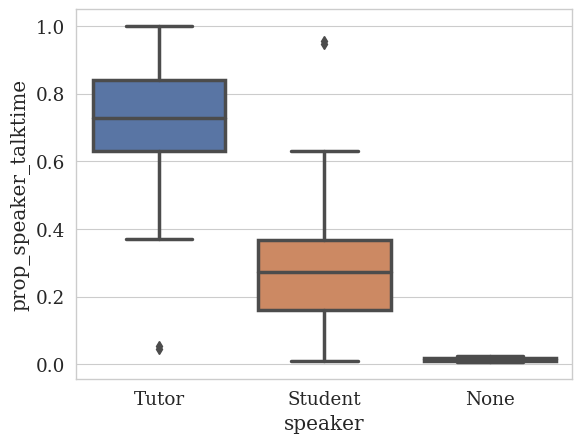

talktime

Proportion statistics
         count      mean       std       min       25%       50%       75%       max
speaker                                                                             
None       2.0  0.014643  0.012308  0.005940  0.010291  0.014643  0.018995  0.023346
Student   44.0  0.304822  0.213351  0.009091  0.159112  0.272535  0.367901  0.955194
Tutor     45.0  0.701301  0.215427  0.044806  0.631480  0.727766  0.840467  1.000000


<Figure size 640x480 with 0 Axes>

In [ ]:
quantitative_analyzer = QuantitativeAnalyzer(data_dir=ANNOTATIONS_DIR)

# Let's plot the talk time ratio between the speakers.
quantitative_analyzer.plot_statistics(
    feature_column=TALK_TIME_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # Proportion of talk time for each speaker.
    value_as="prop"
)

# We can also print the statistics:
quantitative_analyzer.print_statistics(
    feature_column=TALK_TIME_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # Proportion of talk time for each speaker.
    value_as="prop"
)

/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


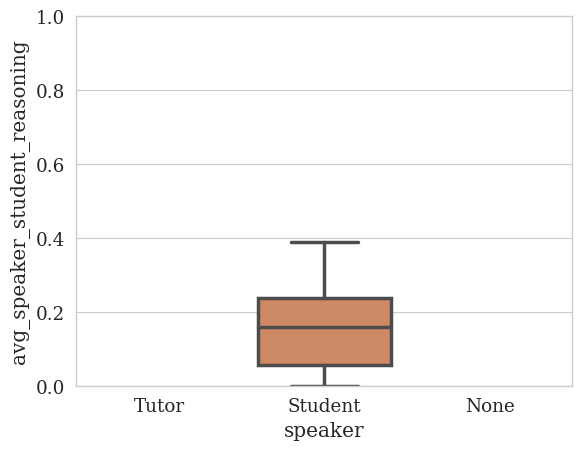

student_reasoning

Average statistics
         count      mean       std  min       25%       50%       75%       max
speaker                                                                        
None       0.0       NaN       NaN  NaN       NaN       NaN       NaN       NaN
Student   38.0  0.154413  0.114317  0.0  0.056493  0.158859  0.238824  0.388889
Tutor      0.0       NaN       NaN  NaN       NaN       NaN       NaN       NaN




/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


<Figure size 640x480 with 0 Axes>

In [ ]:
# What about the student reasoning? How often does the student use reasoning?
quantitative_analyzer.plot_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # We change this to "avg" because we're now looking at within-speaker statistics.
    value_as="avg",
    # We can set the y-axis limits to [0, 1] because the student reasoning column is a binary column.
    yrange=(0, 1)
)

# We can also print the statistics:
quantitative_analyzer.print_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg"
)

Note, the tutor has no `student_reasoning` because we did not annotate the tutor's utterances for student reasoning.
We can easily remove the tutor from the plot by dropping na values:

/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,
/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,
/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,
/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,
/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzer

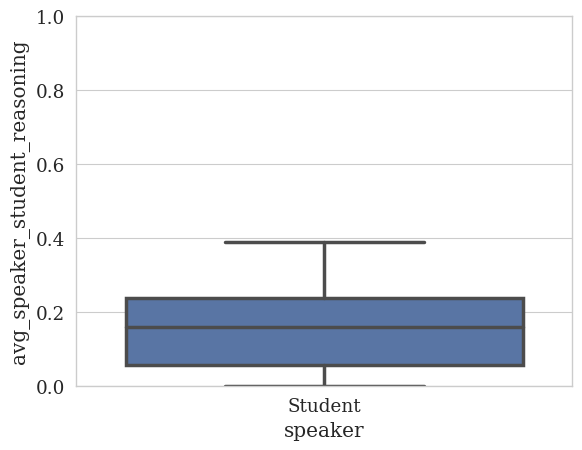

<Figure size 640x480 with 0 Axes>

In [ ]:
quantitative_analyzer.plot_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    yrange=(0, 1),
    dropna=True
)

/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/quantitative_analyzer.py:51: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


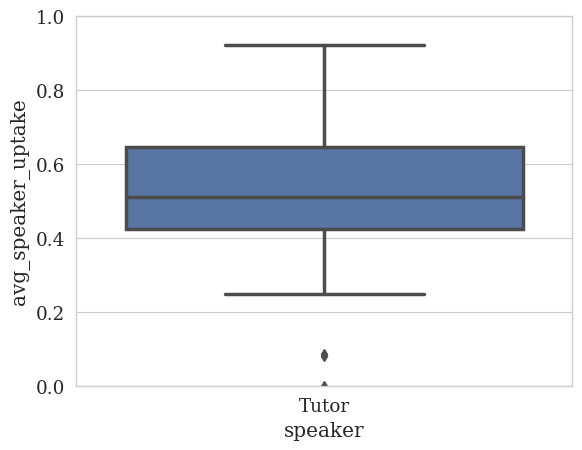

<Figure size 640x480 with 0 Axes>

In [ ]:
# Finally, let's look at the tutor's uptake of the student's utterances.
quantitative_analyzer.plot_statistics(
    feature_column=UPTAKE_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    yrange=(0, 1),
    dropna=True
)

## 💬 Lexical Analysis

In [ ]:
lexical_analyzer = LexicalAnalyzer(data_dir=ANNOTATIONS_DIR)

# Let's look at the most common words per speaker in the dataset.
lexical_analyzer.print_word_frequency(
    text_column=TEXT_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    # We want to look at the top 10 words per speaker.
    topk=10,
    # Let's also format the text (e.g., remove punctuation, lowercase the text, etc.)
    run_text_formatting=True
)


Top Words By Speaker
Tutor
going: 942
miles: 929
okay: 810
like: 789
speed: 727
hour: 715
time: 711
car: 668
yeah: 620
graph: 579


Student
like: 1367
miles: 780
hour: 660
yeah: 564
would: 474
okay: 434
fifty: 431
point: 428
distance: 423
think: 411


None
okay: 4
cool: 1
yeah: 1
average: 1
make: 1
sense: 1
yep: 1
three: 1
four: 1
yes: 1





The language between the two looks pretty similar. Let's run a log-odds analysis to see what words that are more likely to be used by the tutor vs. student.

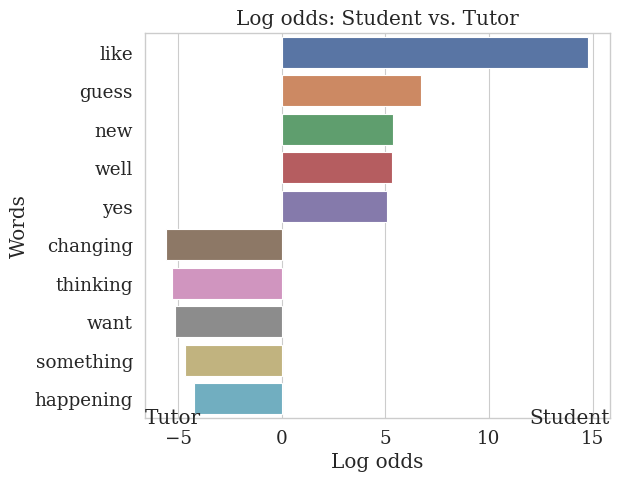

<Figure size 640x480 with 0 Axes>

In [ ]:
# This returns the merged dataframe of the annotated files in DATA_DIR.
df = lexical_analyzer.get_df()

# We want to create two groups of df: one for the student and one for the tutor.
student_df = df[df[SPEAKER_COLUMN] == STUDENT_SPEAKER]
tutor_df = df[df[SPEAKER_COLUMN] == TEACHER_SPEAKER]

# Now we can run the log-odds analysis:
lexical_analyzer.plot_log_odds(
    df1=student_df,
    df2=tutor_df,
    text_column1=TEXT_COLUMN,
    text_column2=TEXT_COLUMN,
    # Let's name the df groups to show on the plot
    group1_name="Student",
    group2_name="Tutor",
    # Let's also run the text formatting
    run_text_formatting=True,
)


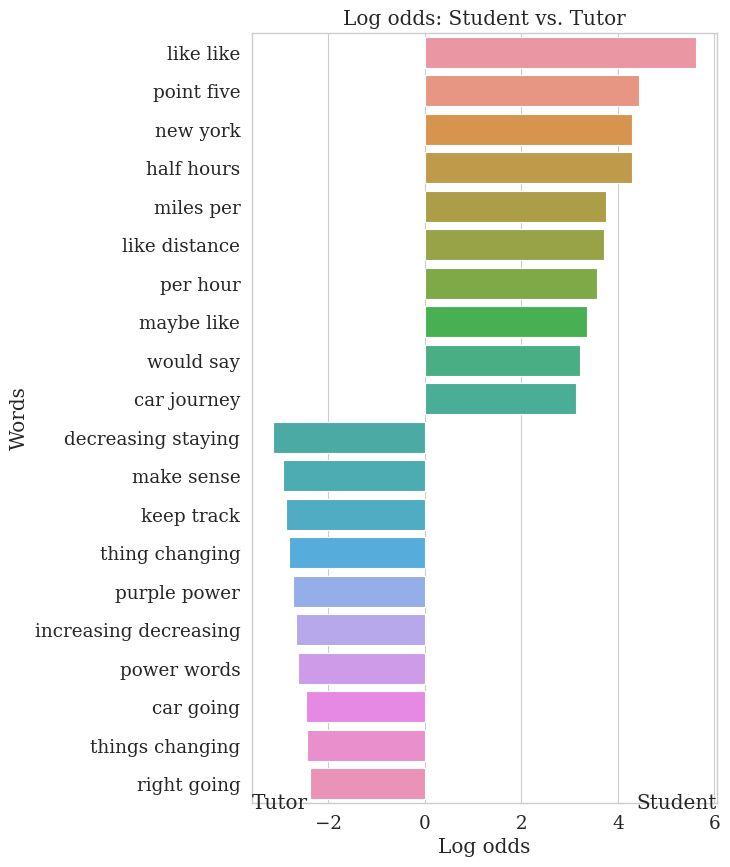

<Figure size 640x480 with 0 Axes>

In [ ]:
# We might also be interested in other n-grams. Let's look at the top 10 bigrams per speaker.
lexical_analyzer.plot_log_odds(
    df1=student_df,
    df2=tutor_df,
    text_column1=TEXT_COLUMN,
    text_column2=TEXT_COLUMN,
    group1_name="Student",
    group2_name="Tutor",
    run_text_formatting=True,
    # n-grams:
    run_ngrams=True,
    n=2,
    topk=10
)

## 📈 Temporal Analysis

Let's look at the temporal trends of the talktime, student reasoning and uptake annotations!

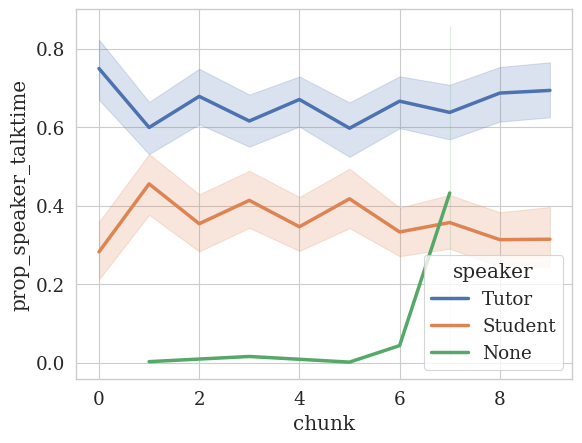

<Figure size 640x480 with 0 Axes>

In [ ]:
temporal_analyzer = TemporalAnalyzer(data_dir=ANNOTATIONS_DIR)

# First let's look at the talk time ratio between the speakers over time.
temporal_analyzer.plot_temporal_statistics(
    feature_column=TALK_TIME_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="prop",
    # Let's create 10 bins for the x-axis.
    num_bins=10
)

/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/temporal_analyzer.py:57: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


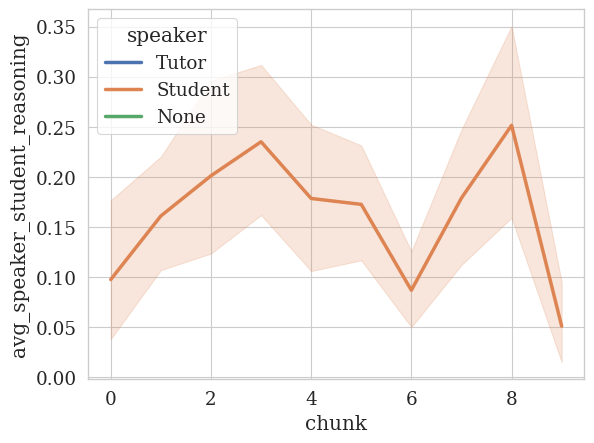

<Figure size 640x480 with 0 Axes>

In [ ]:
# Now student reasoning over time.
temporal_analyzer.plot_temporal_statistics(
    feature_column=STUDENT_REASONING_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    # Let's create 10 bins for the x-axis.
    num_bins=10,
)

/usr/local/lib/python3.10/dist-packages/edu_toolkit/analyzers/temporal_analyzer.py:57: RuntimeWarning: invalid value encountered in double_scalars
  f"prop_speaker_{feature_column}": speaker_df[feature_column].sum() / feature_sum,


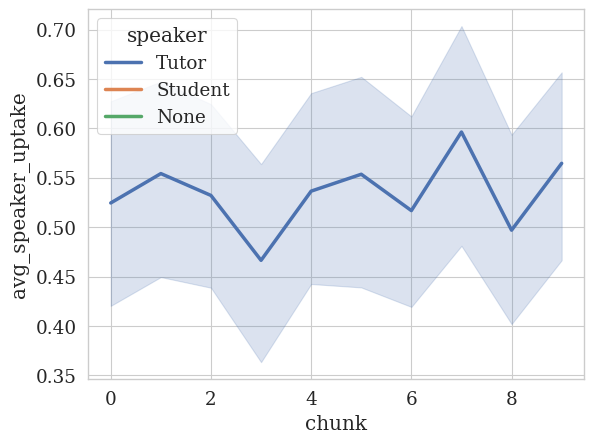

<Figure size 640x480 with 0 Axes>

In [ ]:
# Finally, let's look at the tutor's uptake of the student's utterances over time.
temporal_analyzer.plot_temporal_statistics(
    feature_column=UPTAKE_COLUMN,
    speaker_column=SPEAKER_COLUMN,
    value_as="avg",
    # Let's create 10 bins for the x-axis.
    num_bins=10,
)

## 📚 Conclusions and Next Steps

Great! From this tutorial, we learned how to use `edu-toolkit` to preprocess, annotate and analyze the Amber dataset.
We saw how very simple principles built into `edu-toolkit` can be used to analyze the dataset and gain insights into the data from various perspectives (qualitative, quantitative, lexical and temporal).

Other resources you can check out include:
- [Tutorial on edu-toolkit for the NCTE dataset](https://colab.research.google.com/drive/1k3fn6uY4QRMtPUZN6hpMd6o-0g7fYotg)
- [Tutorial on edu-toolkit for the TalkMoves dataset](https://colab.research.google.com/drive/1qt_S3GjxIwXk6ONztbYAHeX8WHy1uxDd)
- [`edu-toolkit` documentation](https://edu-toolkit.readthedocs.io/en/latest/)
- [`edu-toolkit` GitHub repository](https://github.com/rosewang2008/edu-toolkit/tree/main)

If you have any questions, please feel free to reach out to us on [`edu-toolkit`'s GitHub](https://github.com/rosewang2008/edu-toolkit).

👋 Happy exploring your data with `edu-toolkit`!